In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.1.2+cu118'

In [3]:
import torchvision
print(torchvision.__version__)

0.16.2+cu118


In [4]:
tag_set = []
# 打开文件并逐行读取
with open('tag_set.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # 分割每一行中的标签 再通过空格分隔
        tags = line.strip().split()
        # 更新集合 自动去除重复的标签
        tag_set += tags
tag_set += ['pad']


# 创建标签到索引的映射
label2idx = {label: idx for idx, label in enumerate(tag_set)}

In [5]:
# 数据准备
class NERDataset(Dataset):
    def __init__(self, texts, tags, tokenizer, max_len, label2idx):
        self.texts = texts
        self.tags = tags
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label2idx = label2idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tags = self.tags[idx]

        label_ids = [self.label2idx[label] for label in tags]

        # 编码文本和标签
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        # 创建标签的mask 因为只对真实单词计算loss
        # 用pad标签进行填充
        labels = [self.label2idx['pad']] * self.max_len
        actual_length = min(len(label_ids), self.max_len)
        labels[:actual_length] = label_ids[:actual_length]

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long)
        }


In [6]:
train_texts = []
train_tags = []

# 读取文本文件
with open('data/train.txt', 'r', encoding='utf-8') as file_texts:
    train_texts = [line.strip().replace(' ', '') for line in file_texts if line.strip()]

# 读取标签文件
with open('data/train_TAG.txt', 'r', encoding='utf-8') as file_tags:
    train_tags = [line.strip().split() for line in file_tags if line.strip()]


dev_texts = []
dev_tags = []

# 读取文本文件
with open('data/dev.txt', 'r', encoding='utf-8') as file_texts:
    dev_texts = [line.strip().replace(' ', '') for line in file_texts if line.strip()]

# 读取标签文件
with open('data/dev_TAG.txt', 'r', encoding='utf-8') as file_tags:
    dev_tags = [line.strip().split() for line in file_tags if line.strip()]

# 切割函数
def split_text(texts, tags, batchsize=128):
    '''
    参数:
    texts: 一个包含多个文本序列的列表 每个文本序列是一个字符串列表。
    tags: 一个包含多个标签序列的列表 每个标签序列是一个字符串列表 与texts中的文本序列一一对应。
    batchsize: 一个整数 表示批处理大小 即每个小批次中的文本和标签序列的最大长度。默认值为128。

    返回:
    split_texts: 一个包含多个文本序列的列表 每个文本序列是一个字符串列表。这些文本序列是根据批处理大小从输入的文本序列中分割出来的。
    split_tags: 一个包含多个标签序列的列表 每个标签序列是一个字符串列表 与split_texts中的文本序列一一对应。这些标签序列是根据批处理大小从输入的标签序列中分割出来的。
    '''
    split_texts = []
    split_tags = []
    for (text, tag) in zip(texts, tags):
        if len(text) > batchsize:
            num = int(len(text) / batchsize)
            for i in range(num):
                split_texts.append(text[batchsize * i: batchsize * (i+1)])
                split_tags.append(tag[batchsize * i: batchsize * (i+1)])
        else:
            split_texts.append(text)
            split_tags.append(tag)
    return split_texts, split_tags

# 使用函数切割文本
split_train_texts , split_train_tags= split_text(train_texts, train_tags)
split_dev_texts, split_dev_tags = split_text(dev_texts, dev_tags)

In [7]:
# 加载分词器
tokenizer = BertTokenizer.from_pretrained('./bert_tokenizer')
# 创建训练数据集和验证数据集
train_dataset = NERDataset(split_train_texts, split_train_tags, tokenizer, max_len=128, label2idx=label2idx)
dev_dataset = NERDataset(split_dev_texts, split_dev_tags, tokenizer, max_len=128, label2idx=label2idx)

In [8]:
from BertForClassification import BertForClassification
# 定义模型参数
vocab_size = 21128       # 词汇表大小
hidden_size = 768        # 隐藏层大小
max_position_embeddings = 512  # 序列的最大长度
num_hidden_layers = 4          # Transformer 层的数量
num_attention_heads = 8         # 注意力头的数量
num_labels = len(tag_set)       # 标签数量

# 初始化BERT分类模型对象
model = BertForClassification(vocab_size, max_position_embeddings,\
        num_hidden_layers, hidden_size, num_attention_heads, num_labels)



In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
# 初始化梯度缩放器
scaler = GradScaler()

def evaluate_model(model, dev_dataset, device):
    '''
    参数:
    model: 需要评估的模型。
    dev_dataset: 用于评估模型的数据集。
    device: 用于运行模型的设备，例如'cpu'或'cuda'。

    返回:
    accuracy: 模型在开发集上的准确率。

    在开发集上评估模型的性能
    '''
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)  # 验证时不需要shuffle

    model.eval()  # 设置模型为评估模式
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # 禁用梯度计算
        for batch_idx, batch in enumerate(dev_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # torch.Size([32, 128])
            labels = batch['labels'].to(device)  # 仍需要labels来进行准确率计算
            # torch.Size([32, 128])

            # 移除labels参数 因为我们不希望在评估时进行损失计算或后向传播
            logits = model(input_ids, attention_mask=attention_mask)
            # torch.Size([32, 128, 10])
            
            prob = F.softmax(logits, dim=-1)  # 得到每个位置上每个类别的概率
            # prob: torch.Size([32, 128, 10])

            # 获取最高概率的类别索引 即预测类别
            preds = torch.argmax(prob, dim=-1)  # torch.Size([32, 128])
            
            # 计算正确预测的数量
            # correct = (preds == labels).sum().item()
            # total_correct += correct
            # total_samples += labels.size(0) * labels.size(1)
            
            # 计算正确的预测数量 只考虑非填充部分
            correct = (preds == labels) * attention_mask  # 应用掩码 只有非填充部分的比较结果会被保留
            correct_sum = correct.sum().item()  # 求和并转换为Python标量

            # 更新 total_correct 和 total_samples
            total_correct += correct_sum  # 累加正确的预测数量
            total_samples += attention_mask.sum().item()  # 累加有效的样本数量 即非填充部分的数量

    accuracy = total_correct / total_samples
    return accuracy

def train_model(model, data_loader, optimizer, device):
    '''
    参数:
    model: 需要训练的模型。
    data_loader: 用于训练模型的数据加载器。
    optimizer: 用于优化模型的优化器。
    device: 用于运行模型的设备 在这里是'cuda'。

    返回:
    total_loss / len(data_loader): 模型在训练过程中的平均损失。

    训练模型
    '''
    model.train()
    total_loss = 0
    
    # 使用tqdm来包装data_loader 显示每个batch的进度
    for batch in tqdm(data_loader, desc="Training", leave=False):
        # batch = next(iter(data_loader)) #测试
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()  # 将梯度置零放在循环开始处 以避免潜在的优化问题

        # 自动管理混合精度的上下文
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = model.loss

        # 使用梯度缩放进行反向传播
        scaler.scale(loss).backward()
        scaler.step(optimizer)  # 使用scaler来更新模型参数
        scaler.update()  # 更新缩放器

        total_loss += loss.item()
    
    return total_loss / len(data_loader)
    # return total_loss

# 假设你已经定义了train_dataset, model, optimizer, device
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_losses = []
validation_accuracies = []
# 使用tqdm显示整个训练过程的进度
for epoch in range(5):
    loss = train_model(model, train_loader, optimizer, device)
    # 验证
    validation_accuracy = evaluate_model(model, dev_dataset, device)
    
    print(f"Epoch {epoch+1}, Train Loss: {loss:.4f}, Validation Accuracy: {validation_accuracy*100:.2f}%")
    # 收集每个epoch的数据
    train_losses.append(loss)
    validation_accuracies.append(validation_accuracy)

Epoch 1, Train Loss: 0.1672, Validation Accuracy: 96.92%


Epoch 2, Train Loss: 0.0851, Validation Accuracy: 97.45%


Epoch 3, Train Loss: 0.0650, Validation Accuracy: 98.08%


Epoch 4, Train Loss: 0.0538, Validation Accuracy: 98.20%


Epoch 5, Train Loss: 0.0462, Validation Accuracy: 98.33%


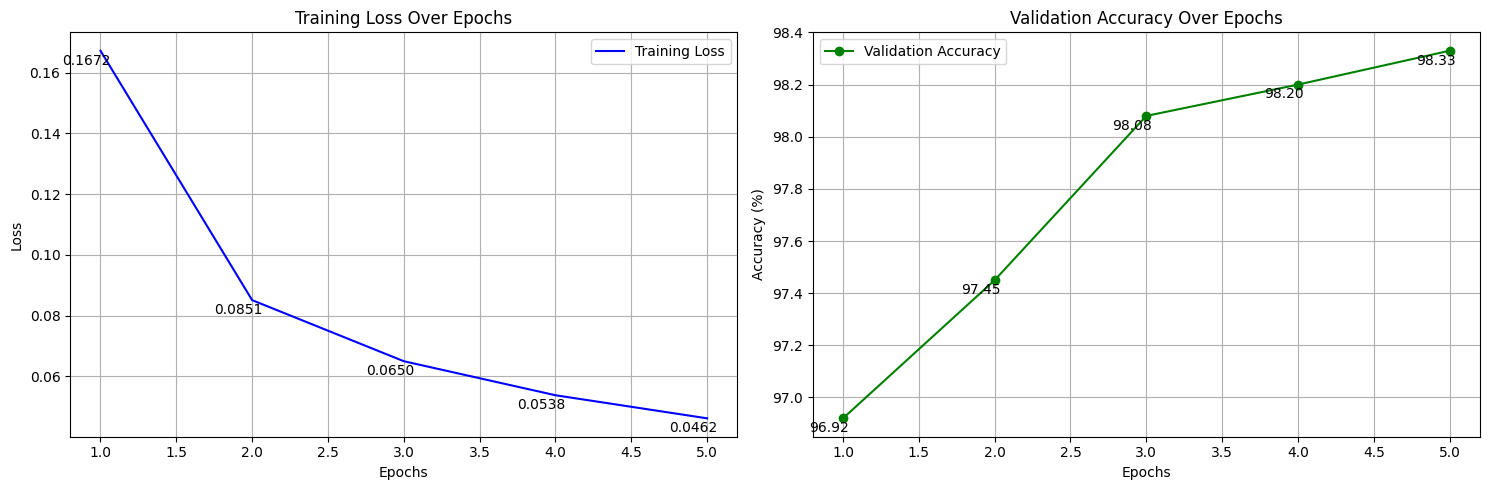

In [2]:
# 创建一个画布 包含两个子图
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# 绘制训练损失曲线
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
for i, loss in enumerate(train_losses, start=1):
    axs[0].annotate(f'{loss:.4f}', (i, loss), textcoords="offset points", xytext=(-10,-10), ha='center')

axs[0].set_title('Training Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid(True)
axs[0].legend()

# 绘制验证准确率曲线
axs[1].plot(range(1, len(validation_accuracies) + 1), [acc for acc in validation_accuracies], 
             label='Validation Accuracy', color='green', marker='o')
for i, acc in enumerate(validation_accuracies, start=1):
    axs[1].annotate(f'{acc:.2f}', (i, acc), textcoords="offset points", xytext=(-10,-10), ha='center')

axs[1].set_title('Validation Accuracy Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid(True)
axs[1].legend()

# 调整子图间距
plt.tight_layout()

plt.show()

In [ ]:
# 下载并保存模型到指定目录
# 保存模型参数
torch.save(model.state_dict(), 'bert_classifier_model.pth')
